In [75]:
import pandas as pd
import numpy as np
import os
import sqlite3
import datetime

# //*** Imports and Load Data
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

output_width = 1000
#output_width = 80 #//*** Normal Output width

#//*** Normal Output width
pd.set_option("display.width", output_width)

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


Work with the Data for Term Project

Data is downloaded using DSC540 StoneburnerKurt TermProject _ Load_PreProcess_Data
which I supposed should be added as an external library if this was a production project.

Coded is separated to keep the project more manageable

In [76]:
#//*** Load all data from a database 
db_filename = 'covid_data.sqldb'

#//*** Verify database instance exists
if os.path.exists(db_filename) == False:
    #//*** Throw a warning if databse does not exist
    print(f"Trouble Connecting to database: {db_filename}")
else:
    #//*** Start a database connection
    con = sqlite3.connect(db_filename)
    
    #//*** Use a manual list of names to convert from SQL. This is much less elegant coming out
    #//*** Than it did going in. But it is expedient
    
    for df_name in ['covid_ethnic_df','covid_cases_df','pop_attrib_df','covid_project_df']:

        #//******************************************    
        #//*** Build loop_df based on string name
        #//******************************************
        if df_name == 'covid_ethnic_df':
            covid_ethnic_df = pd.read_sql(f"SELECT * FROM {df_name}",con=con)
        elif df_name == 'covid_cases_df':
            covid_cases_df = pd.read_sql(f"SELECT * FROM {df_name}",con=con).set_index('index')
        elif df_name == 'pop_attrib_df':
            pop_attrib_df = pd.read_sql(f"SELECT * FROM {df_name}",con=con).set_index('index')
        elif df_name == 'covid_project_df':
            covid_project_df = pd.read_sql(f"SELECT * FROM {df_name}",con=con).set_index('index')
            covid_project_df['date'] = pd.to_datetime(covid_project_df['date'])
        else:
            #//*** Display and error message for items missed. 
            print(f"Failed to process: {df_name}")
            continue

        

        #print(con.execute(query).fetchall())
        
        

    #//*** Close and Exit the Database. For 
    con.close()
    con.__exit__


In [77]:
#//*** Set the index column as the index
for df in [covid_ethnic_df, covid_cases_df, pop_attrib_df,covid_project_df]:
    if 'index' in df.columns:
        df = df.set_index('index')

In [78]:
#//*************************************
#//*** Import stored/preprocessed data
#//*************************************

#//*** Columns to remove from imported CSVs. We should be able to kill these on import if we were cool.
#//*** But we're not, so we'll use an expedient column delete list.

del_cols = ['Unnamed: 0', '_id']
#//*** Load datframes from file, because we mess them up
#covid_ethnic_df = pd.read_csv("z_covid_ethnic_df.csv")
#covid_cases_df = pd.read_csv("z_covid_cases_df.csv")
#pop_attrib_df = pd.read_csv("z_pop_attrib_df.csv")
#covid_project_df = pd.read_csv("z_covid_project_df.csv")

#//***********************************************************************************
#//*** Remove excess columns from read_csv
#//*** Use the loop in case we need to delete columns that are not exclusive to all
#//***********************************************************************************
for x in del_cols:
    if x in covid_cases_df.columns:
        covid_cases_df.drop([x], axis=1, inplace=True)

    if x in covid_ethnic_df.columns:
        covid_ethnic_df.drop([x], axis=1, inplace=True)
    
    if x in pop_attrib_df.columns:
        pop_attrib_df.drop([x], axis=1, inplace=True)
    
    if x in covid_project_df.columns:
        covid_project_df.drop([x], axis=1, inplace=True)
        
print(covid_cases_df.head())

#//*** Drop the counties labeled as unassigned.
#//*** We don't have data on those individuals
print(f"Length Before removing Unassigned County: {len(covid_cases_df)}")

covid_cases_df = covid_cases_df[~covid_cases_df['county'].isin(['Unassigned'])]

print(f"Length After removing Unassigned County: {len(covid_cases_df)}")

#//*** Remove the 'Out Of Country' listings
print(f"Length Before removing Out Of Country County: {len(covid_cases_df)}")

covid_cases_df = covid_cases_df[~covid_cases_df['county'].isin(['Out Of Country'])]

print(f"Length After removing Out Of Country County: {len(covid_cases_df)}")


#//*** Drop the rows with Other listed as ethnicity. This reopresents less than .1 % pf the population and doesn't have an
#//*** Equivalent in the federal data.
print(f"Length Before removing Other Race: {len(covid_ethnic_df)}")

covid_ethnic_df = covid_ethnic_df[~covid_ethnic_df['race_ethnicity'].isin(['Other'])]

print(f"Length After removing Other Race: {len(covid_ethnic_df)}")



            county  totalcountconfirmed  totalcountdeaths  newcountconfirmed  newcountdeaths                 date
index                                                                                                            
0      Santa Clara                151.0               6.0                151               6  2020-03-18T00:00:00
14978   Sacramento                 46.0               3.0                 46               3  2020-03-18T00:00:00
14642  Los Angeles                 47.0               0.0                 47               0  2020-03-18T00:00:00
14308         Napa                  0.0               0.0                  0               0  2020-03-18T00:00:00
19651         Yolo                  4.0               0.0                  4               0  2020-03-18T00:00:00
Length Before removing Unassigned County: 19985
Length After removing Unassigned County: 19651
Length Before removing Out Of Country County: 19651
Length After removing Out Of Country County: 19342
Leng

In [79]:
print(covid_ethnic_df['race_ethnicity'].unique())

['Latino' 'Native Hawaiian or Pacific Islander'
 'American Indian or Alaska Native' 'Asian' 'White' 'Black' 'Multiracial'
 'Native Hawaiian and other Pacific Islander' 'Multi-Race']


In [80]:
#//*** Combine Pacific Islander and Hawaiian values into one.
#//*** Hawaiian isn't a good choice of variable name. It's kind of racist and definitely non-inclusive.
#//*** But I need this to work, before I can reconsider a different variable name

covid_ethnic_df['race_ethnicity']=covid_ethnic_df['race_ethnicity'].str.replace('Native Hawaiian or Pacific Islander','Hawaiian')
covid_ethnic_df['race_ethnicity']=covid_ethnic_df['race_ethnicity'].str.replace('Native Hawaiian and other Pacific Islander','Hawaiian')
covid_ethnic_df['race_ethnicity']=covid_ethnic_df['race_ethnicity'].str.replace('Multi-Race','Multiracial' )
covid_ethnic_df['race_ethnicity']=covid_ethnic_df['race_ethnicity'].str.replace('American Indian or Alaska Native','Native' )

In [81]:
#print(pop_attrib_df)

HTML(pop_attrib_df.to_html())

,cty_fibs,county,population,Latino,White,Asian,Black,American Indian or Alaska Native,Hawaiian,Multiracial,0rf_num,0rf_rate,0rf_err,1-2rf_num,1-2rf_rate,1-2rf_err,3plrf_num,3plrf_rate,3plrf_err
index,,,,,,,,,,,,,,,,,,,
0,1,Alameda,1671329,373055,512134,529698,169954,4157,13474,68857,52135,3.16,1.99,1159312,70.37,6.98,436060,26.47,6.84
1,3,Alpine,1129,139,692,18,4,243,0,33,241,21.89,8.40,579,52.59,10.35,281,25.52,9.31
2,5,Amador,39752,5753,30742,575,994,606,83,999,7169,20.35,5.97,17817,50.59,7.16,10235,29.06,6.49
3,7,Butte,219186,37731,155415,10573,3526,3390,465,8086,44433,19.46,5.32,122804,53.79,6.88,61078,26.75,6.02
4,9,Calaveras,45905,5967,36672,719,420,562,98,1467,9940,21.93,6.38,22900,50.53,7.46,12478,27.53,6.60
5,11,Colusa,21547,13018,7344,266,220,293,73,333,4223,19.65,5.75,12343,57.45,7.10,4920,22.90,6.19
6,13,Contra Costa,1153526,300420,492393,204045,100798,3126,5379,47365,150886,13.16,3.91,710710,61.99,6.99,284932,24.85,6.49
7,15,Del Norte,27812,5596,17236,802,917,2059,42,1160,5189,20.77,6.47,13874,55.54,7.66,5915,23.68,6.47
8,17,El Dorado,192843,25378,148903,8974,1696,1500,328,6064,55253,29.06,6.34,94483,49.69,7.03,40421,21.26,5.76


In [82]:

#//*** Combine covid_project State numbers with covid_cases_df, This gives us State wide numbers to reference

#//*** Sort Both dataframes by date
covid_cases_df = covid_cases_df.sort_values(by='date')
covid_project_df = covid_project_df.sort_values(by='date')



#//********************************************************
#//*** trim COVID project dates to match covid_cases
#//********************************************************
#//*** Get the First date of the covid_cases_df. This is our target for the slice
cases_start_date = covid_cases_df['date'].iloc[0]


project_start_iloc = covid_project_df.index.get_loc(covid_project_df[ covid_project_df['date'] == cases_start_date].iloc[0].name)
#print(covid_project_df[project_start_iloc:])
covid_project_df = covid_project_df[project_start_iloc:]

#for group in covid_cases_df.groupby('date'):
#    print(group[1].head(5))
    

#//*** Synchronize end date
last_iloc = len(covid_project_df)-1

print(f"These Should be equal: {last_iloc == len(covid_project_df[:last_iloc])}")

#//*** Synchronize the end date
last_iloc =  len(covid_cases_df.groupby('date'))

#//*** If these are the same, then no issue.
#//*** If COVID Project is Longer then it will trim to size.
#//*** If Cases are longer, i'll need code to trim the other way.
covid_project_df = covid_project_df[:last_iloc]



#//*** Get the total entries per day
#//*** We'll use this value to generate a duplicate state population to be associated with every county
#number_of_entries = len(covid_cases_df[covid_cases_df['date'] == cases_start_date])


state_confirmed = []

for date in covid_cases_df['date'].unique():
    #print(f"{len(covid_cases_df[ covid_cases_df['date'] == date ])} {date} {covid_project_df[ covid_project_df['date'] == date]['date'].iloc[0]}")
    for _ in range(len(covid_cases_df[ covid_cases_df['date'] == date ])):
        state_confirmed.append(covid_project_df[ covid_project_df['date'] == date]['confirmed'].iloc[0])

print(f"These Should be Equal: {len(state_confirmed)} {len(covid_cases_df)}")

#//*** Add the State Totals to the County Values
covid_cases_df['state_confirmed'] = state_confirmed


These Should be equal: True
These Should be Equal: 19342 19342


In [83]:
print(covid_cases_df)

                county  totalcountconfirmed  totalcountdeaths  newcountconfirmed  newcountdeaths                 date  state_confirmed
index                                                                                                                                 
0          Santa Clara                151.0               6.0                151               6  2020-03-18T00:00:00              611
18983           Amador                  0.0               0.0                  0               0  2020-03-18T00:00:00              611
1004          Tuolumne                  0.0               0.0                  0               0  2020-03-18T00:00:00              611
18649           Plumas                  0.0               0.0                  0               0  2020-03-18T00:00:00              611
2005   San Luis Obispo                  5.0               0.0                  5               0  2020-03-18T00:00:00              611
...                ...                  ...            

In [84]:
#//*** Sort Time Series by date and reset index
covid_cases_df = covid_cases_df.sort_values(by='date')
covid_ethnic_df = covid_ethnic_df.sort_values(by='date')

#//*** Reset the index
#covid_ethnic_df.reset_index(inplace=True)





#//*** Get first Ethnic_df date
ethnic_start_date = covid_ethnic_df['date'].iloc[0]
print(f"Ethinic State: {ethnic_start_date}")

#//*************************************************************************************************
#//*** Get the iloc (index #) of the first covid_case_df entry to match the date in covid_ethic_df
#//*** Compound code
#//*** 1. Get the entries where the date matches ethnic start date
#//*** 2. Get the first value from the list
#//*** 3. Get the Index (name) of that entry
#//*** 4. Get the iloc value of the name entry. This is the value to slice from covid_cases_df
#//*************************************************************************************************
#//*** I hate these, but I see the appeal
#//*************************************************************************************************
covid_start_iloc = covid_cases_df.index.get_loc(covid_cases_df[ covid_cases_df['date'] == ethnic_start_date].iloc[0].name)

#print(covid_cases_df.iloc[covid_start_iloc])
#//*** Merge Time Series covid_ethnic_df - covid_cases_df
covid_cases_df = covid_cases_df.iloc[covid_start_iloc:]

#//*** Start the Bg Table DF with a subset of
#bt_df = covid_ethnic_df
#print
#print(covid_ethnic_df.head())
#print(bt_df.head())
    
    
bt_df = pd.merge(covid_ethnic_df,covid_cases_df,how='left', on='date')

bt_df = pd.merge(bt_df,pop_attrib_df,how='left', on='county')

if 'index' in bt_df.columns:
    bt_df.drop(['index'], axis=1, inplace=True)

print(f"Total Rows: {len(bt_df)}")

#for group in bt_df.groupby('date'):
#    print(group[1])
#    break

Ethinic State: 2020-04-13T00:00:00
Total Rows: 125048


In [85]:
#//*** Rename Columns
g = {
    "bt_rename" : {
        "race_ethnicity" : "race",
        "case_percentage" : "case_percent",
        "death_percentage" : "death_percent",
        "percent_ca_population" : "percent_ca_pop",
        "totalcountconfirmed" : "confirmed",
        "totalcountdeaths" : "deaths",
        "newcountconfirmed" : "newconfirm",
        "newcountdeaths" : "newdeath",
        "population" : "pop",
        "American Indian or Alaska Native" : "Native"
    }
}
bt_df = bt_df.rename(columns = g["bt_rename"])

cols = list(bt_df.columns)

#//*** Verify values in race column match the attribute columns.
#//*** Double checking our renaming work. It's good to make sure we have everything aligned going in.

print(cols)
for race in bt_df['race'].unique():
    print(f"{race} {race in cols}")

#//*** After much retcon the columns and data match

#//*** Convert the date column from datetime to date
bt_df['date'] = pd.to_datetime(bt_df['date']).dt.date



['race', 'cases', 'case_percent', 'deaths', 'death_percent', 'percent_ca_pop', 'date', 'county', 'confirmed', 'deaths', 'newconfirm', 'newdeath', 'state_confirmed', 'cty_fibs', 'pop', 'Latino', 'White', 'Asian', 'Black', 'Native', 'Hawaiian', 'Multiracial', '0rf_num', '0rf_rate', '0rf_err', '1-2rf_num', '1-2rf_rate', '1-2rf_err', '3plrf_num', '3plrf_rate', '3plrf_err']
Latino True
Hawaiian True
Native True
Asian True
White True
Black True
Multiracial True


In [86]:
#//*** Reduce Excess Columns.
#//*** Build ethnic_pop columns which is the population of the identified race_ethnicity for the row.
#//*** Each daily entry is by race and county. Only one race value is applicable per row.\
#//*** Build a new column that indicates the county population of that category
#//*** Build a new column that indicates the percentage of that race in that county.

#//*** Temporary lists to convert to columns
cty_ethnic_pop = []
cty_ethnic_percent = []

#//*** Loop through each row of bt_df
for index,row in bt_df.iterrows():
    try:
        #//*** get the value from the appropriate row['race'] column.
        #//*** Example if row['race'] == 'Latino'
        #//*** Get the 'Latino' population for the county, which would be row ['Latino']
        cty_ethnic_pop.append( row [ row['race'] ] )

        #//*** Build the percentage of racial population in county.
        cty_ethnic_percent.append( row [ row['race'] ] / row [ 'pop'] )

    except: 
        #//*** Stop and print failing atributes
        #//*** These should all be retcon appropriate
        print(f"{row['race']} {row['county']}")
        break

#//*** For readability, replace Latino and White columns with ethnic_pop and ethnic_percent
bt_df['Latino'] = pd.Series(data=cty_ethnic_pop)
bt_df['White'] = pd.Series(data=cty_ethnic_percent)


#//*** Remove excess columns
for col in ['cty_fibs', 'Asian', 'Black', 'Native', 'Hawaiian', 'Multiracial']:
    if col in bt_df.columns:
        bt_df.pop(col)

        
#//*** Rename Latino column to pop_race        
if 'Latino' in bt_df.columns:
    bt_df = bt_df.rename(columns = {'Latino' : 'pop_race'})

#//*** Rename White column to percent_cty_pop        
if 'White' in bt_df.columns:
    bt_df = bt_df.rename(columns = {'White' : 'percent_cty_pop'})



In [87]:
print(len(bt_df))
#//*** Print a few rows from each day to get a feel for the total data
for group in bt_df.groupby('date'):
    print(group[1].head(5))

    


125048
     race  cases  case_percent  deaths  death_percent  percent_ca_pop        date       county  confirmed  deaths  newconfirm  newdeath  state_confirmed       pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
0  Latino   5276         35.99     170          28.38            38.9  2020-04-13      Ventura      311.0     9.0           5         0            22348    846006    365835         0.432426    79671      9.42     3.35     535084       63.26       7.11     231114       27.32       6.76
1  Latino   5276         35.99     170          28.38            38.9  2020-04-13  Los Angeles     9367.0   320.0         234        24            22348  10039107   4881970         0.486295   294048      2.94     2.00    6698377       66.87       7.15    3024086       30.19       7.03
2  Latino   5276         35.99     170          28.38            38.9  2020-04-13         Napa       30.0     2.0           1         0

10154  Black   2659           6.2     252           10.3             6.0  2020-05-08   Siskiyou        5.0     0.0           0         0            62512    43539       612         0.014056     9271     21.37     6.01      21607       49.81       7.03      12501       28.82       6.19
           race  cases  case_percent  deaths  death_percent  percent_ca_pop        date         county  confirmed  deaths  newconfirm  newdeath  state_confirmed     pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
10556  Hawaiian    454           1.0      24            0.9             0.3  2020-05-09      Del Norte        3.0     0.0           0         0            64561   27812        42         0.001510     5189     20.77     6.47      13874       55.54       7.66       5915       23.68       6.47
10557  Hawaiian    454           1.0      24            0.9             0.3  2020-05-09           Mono       27.0     1.0         

21928  Hawaiian    683           0.7      21            0.5             0.3  2020-06-06    Imperial     3047.0    33.0         269         0           126016  181215       122         0.000673    11322      6.52     3.74     101655       58.55       8.14      60654       34.93       7.76
        race  cases  case_percent  deaths  death_percent  percent_ca_pop        date          county  confirmed  deaths  newconfirm  newdeath  state_confirmed      pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
22330  White  17640          19.0    1481           33.3            36.6  2020-06-07            Napa      142.0     3.0           6         0           128812   137744     71291         0.517562    15295     11.08     3.81      81947       59.35       7.36      40841       29.58       7.04
22331  White  17640          19.0    1481           33.3            36.6  2020-06-07       El Dorado      104.0     0.0          

34108  Native    359           0.2      23            0.4             0.5  2020-07-06  San Benito      264.0     2.0           6         0           271684    62808       247         0.003933     5128      8.34     2.66      41001       66.66       6.98      15381       25.01       6.79
         race  cases  case_percent  deaths  death_percent  percent_ca_pop        date       county  confirmed  deaths  newconfirm  newdeath  state_confirmed     pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
34510  Native    381           0.2      23            0.4             0.5  2020-07-07    Del Norte       57.0     0.0           0         0           277774   27812      2059         0.074033     5189     20.77     6.47      13874       55.54       7.66       5915       23.68       6.47
34511  Native    381           0.2      23            0.4             0.5  2020-07-07         Kern     5645.0    84.0         154       

46288  Latino  201559          58.4    4438           46.7            38.9  2020-08-05  Stanislaus     9408.0   145.0          49        10           524722  550660    262068         0.475916    28796      5.26     2.88     363715       66.42       7.24     155104       28.32       6.98
           race  cases  case_percent  deaths  death_percent  percent_ca_pop        date       county  confirmed  deaths  newconfirm  newdeath  state_confirmed      pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
46690  Hawaiian   2034           0.6      48            0.5             0.3  2020-08-06       Sierra        3.0     0.0           0         0           529980     3005         3         0.000998      592     19.82     8.62       1418       47.47      10.31        977       32.71       9.45
46691  Hawaiian   2034           0.6      48            0.5             0.3  2020-08-06  Santa Clara    11280.0   196.0         20

59280  Asian  27060           5.5    1575           11.7            15.4  2020-09-06     Napa     1501.0    13.0          17         0           732144  137744     11698         0.084926    15295     11.08     3.81      81947       59.35       7.36      40841       29.58       7.04
         race   cases  case_percent  deaths  death_percent  percent_ca_pop        date    county  confirmed  deaths  newconfirm  newdeath  state_confirmed     pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
59682  Latino  301026          60.5    6520           48.4            38.9  2020-09-07  Mariposa       72.0     2.0           0         0           735235   17203      2073         0.120502     3625     20.92     6.25       8968       51.75       7.40       4738       27.34       6.64
59683  Latino  301026          60.5    6520           48.4            38.9  2020-09-07      Mono      145.0     2.0           0         0        

71460  Native   1588           0.3      48            0.3             0.5  2020-10-06    Mono      153.0     2.0           1         0           828461   14444       267         0.018485     3805     26.81     7.76       7519       52.99       8.87       2866       20.20       7.23
         race  cases  case_percent  deaths  death_percent  percent_ca_pop        date         county  confirmed  deaths  newconfirm  newdeath  state_confirmed     pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
71862  Native   1606           0.3      49            0.3             0.5  2020-10-07           Lake      599.0    12.0           3         0           831225   64386      1629         0.025301    13872     21.68     6.15      33225       51.94       7.14      16875       26.38       6.17
71863  Native   1606           0.3      49            0.3             0.5  2020-10-07          Marin     6790.0   124.0          24      

83234  White  119441          17.8    5330           30.2            36.6  2020-11-04       Humboldt      571.0    10.0           1         0           940010  135558    100078         0.738267    28592     21.41     5.51      71198       53.33       6.97      33727       25.26       6.02
         race   cases  case_percent  deaths  death_percent  percent_ca_pop        date        county  confirmed  deaths  newconfirm  newdeath  state_confirmed      pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
83636  Latino  411702          60.8    8610           48.5            38.9  2020-11-05   Santa Clara    25651.0   424.0         164         3           944576  1927852    482298         0.250174    74471      3.88     2.11    1373320       71.51       6.70     472797       24.62       6.55
83637  Latino  411702          60.8    8610           48.5            38.9  2020-11-05       Ventura    15113.0   169.0         

95414  Native   2885           0.3      66            0.3             0.5  2020-12-04   Sacramento    41061.0   614.0         781        11          1286557  1552058      7792         0.005020    86851      5.68     2.56    1016722       66.47       6.99     425977       27.85       6.79
         race  cases  case_percent  deaths  death_percent  percent_ca_pop        date           county  confirmed  deaths  newconfirm  newdeath  state_confirmed      pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
95816  Native   2949           0.3      65            0.3             0.5  2020-12-05        San Diego    90470.0  1055.0        2287         8          1311625  3338330     14345         0.004297   337449     10.21     3.84    2125966       64.32       7.13     841664       25.47       6.61
95817  Native   2949           0.3      65            0.3             0.5  2020-12-05         Mariposa      143.0     3.0    

107188  Multiracial  22331           1.3     281            1.1             2.2  2021-01-02       Tulare    34479.0    406.0         485         0          2345909    466195      6690         0.014350    46747     10.08     3.89     280395       60.44       7.05     136751       29.48       6.55
          race  cases  case_percent  deaths  death_percent  percent_ca_pop        date      county  confirmed  deaths  newconfirm  newdeath  state_confirmed     pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
107590  Native   5498           0.3      85            0.3             0.5  2021-01-03      Amador     2565.0    24.0          25         0          2391261   39752       606         0.015245     7169     20.35     5.97      17817       50.59       7.16      10235       29.06       6.49
107591  Native   5498           0.3      85            0.3             0.5  2021-01-03      Tulare    34742.0   406.0         2

120180  White  499316          19.9   12968           31.8            36.6  2021-02-03         Lassen     4910.0    17.0           2         0          3281271    30573     19796         0.647499     6083     26.03     6.11      11664       49.91       7.04       5624       24.06       5.91
          race    cases  case_percent  deaths  death_percent  percent_ca_pop        date    county  confirmed  deaths  newconfirm  newdeath  state_confirmed     pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
120582  Latino  1389409          55.0   19117           46.1            38.9  2021-02-04      Napa     8573.0    58.0          39         0          3294447  137744     47660         0.346004    15295     11.08     3.81      81947       59.35       7.36      40841       29.58       7.04
120583  Latino  1389409          55.0   19117           46.1            38.9  2021-02-04     Modoc      309.0     4.0           1   

In [88]:
# //*** Legends automatically generate too many labels based on my looping method.
# //*** Remove the Duplicate Legends. I wrote this for DSC 530 and it keeps on giving.
def deduplicate_legend(input_ax):
    # //**** Get handle and label list for the current legend
    # //**** Use first instance, toss the rest.
    handles, labels = input_ax.get_legend_handles_labels()

    handle_dict = {}

    for x in range(len(labels)):
        if labels[x] not in handle_dict.keys():
            # //*** Label = handle
            handle_dict[labels[x]] = handles[x]

    # //*** Build unique output ists and handles
    out_handles = []
    out_labels = []
    
    for label,handle in handle_dict.items():
        out_handles.append(handle)
        out_labels.append(label)
    
    return out_handles,out_labels

   

In [89]:
#for col in covid_project_df:
#    print(f'{covid_project_df[col].str.replace("[","").str.replace("]","")}')

In [90]:
race_list = bt_df['race'].unique()
print(race_list)
print(len(bt_df))

#//*** Initialize race Dict
rd = {}

for race in race_list:
    rd[race] = bt_df [ bt_df['race'] == race ] 
#print( bt_df [ bt_df['race'] == 'Latino'] )

for race in race_list:
    print(rd[race].head(10))


['Latino' 'Hawaiian' 'Native' 'Asian' 'White' 'Black' 'Multiracial']
125048
     race  cases  case_percent  deaths  death_percent  percent_ca_pop        date         county  confirmed  deaths  newconfirm  newdeath  state_confirmed       pop  pop_race  percent_cty_pop  0rf_num  0rf_rate  0rf_err  1-2rf_num  1-2rf_rate  1-2rf_err  3plrf_num  3plrf_rate  3plrf_err
0  Latino   5276         35.99     170          28.38            38.9  2020-04-13        Ventura      311.0     9.0           5         0            22348    846006    365835         0.432426    79671      9.42     3.35     535084       63.26       7.11     231114       27.32       6.76
1  Latino   5276         35.99     170          28.38            38.9  2020-04-13    Los Angeles     9367.0   320.0         234        24            22348  10039107   4881970         0.486295   294048      2.94     2.00    6698377       66.87       7.15    3024086       30.19       7.03
2  Latino   5276         35.99     170          28.38       

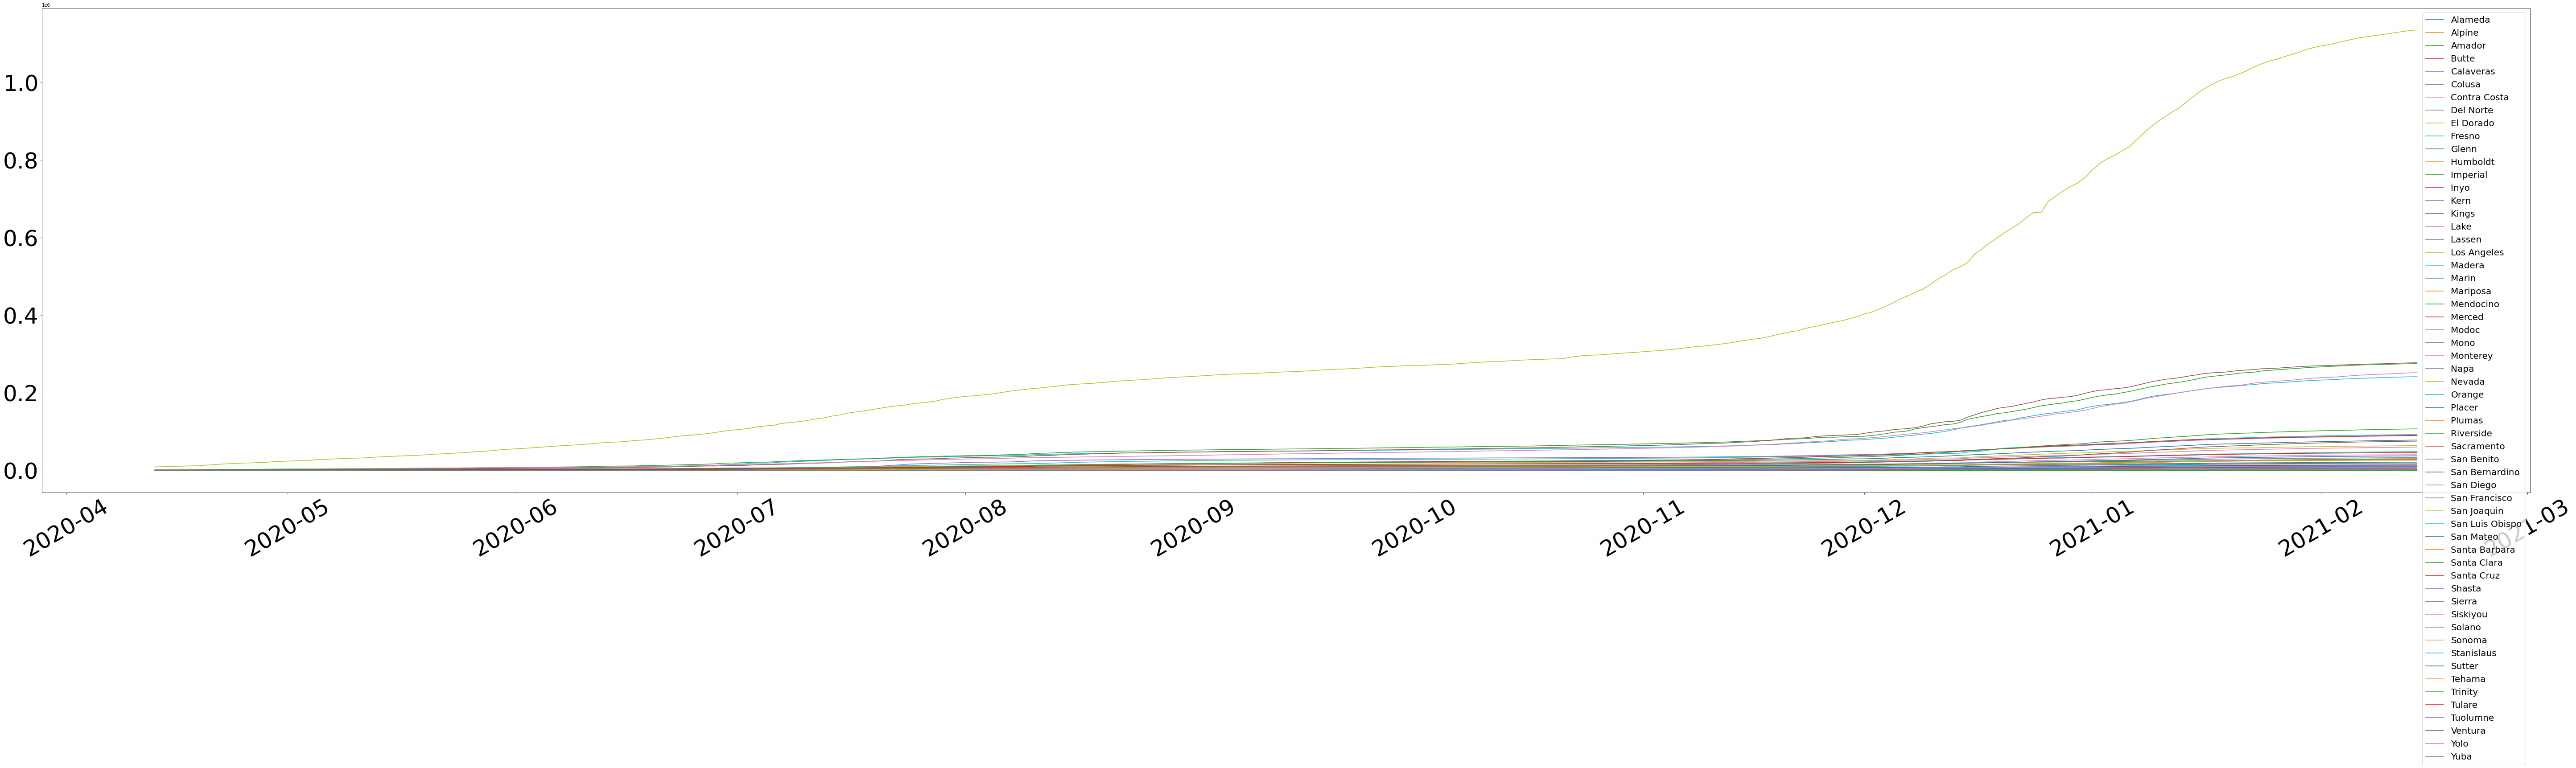

In [91]:
#rint(rd["Latino"].groupby("county"))
plt.rcParams['figure.figsize'] = [100, 20] 
plt.rcParams.update({'figure.max_open_warning': 0})

display_size = 20
fig,ax = plt.subplots()
for group in rd["Latino"].groupby("county"):
    loop_df = group[1]
    
   
    ax.plot(loop_df['date'],loop_df['confirmed'], label=loop_df["county"].iloc[0])


        
plt.xticks(rotation=30,fontsize=50)
plt.yticks(fontsize=50)

handles,labels = deduplicate_legend(ax)
plt.legend(fontsize=display_size)
    #plt.legend(handles,labels, fontsize=display_size)
    #plt.title(f"Histogram of Joy with {display_count} elements\n({graph_loop+1} of {int( (len(candy_cols)/ display_count))})",fontsize=display_count*2)
plt.show()
    
    
    

In [92]:
#//*** Let's run some correllations for funsies
pop_cols = ['population', 'Latino','White','Asian','Black','American Indian or Alaska Native', 'Hawaiian' ]
rf_cols = ['0rf_num', '1-2rf_num',  '3plrf_num']
rf_cols = ['0rf_rate', '1-2rf_rate',  '3plrf_rate']

for x in pop_cols:
    for y in rf_cols:
        print(f"{x} {y} - {pop_attrib_df[ [x,y] ].corr().iloc[0].iloc[1] }")

population 0rf_rate - -0.4567961826407012
population 1-2rf_rate - 0.45180422307614304
population 3plrf_rate - 0.1425255103467081
Latino 0rf_rate - -0.40905527183588614
Latino 1-2rf_rate - 0.3837575774517347
Latino 3plrf_rate - 0.1806483757865183
White 0rf_rate - -0.464199120421134
White 1-2rf_rate - 0.4797158976341499
White 3plrf_rate - 0.09234516802071475
Asian 0rf_rate - -0.5087228664495507
Asian 1-2rf_rate - 0.5231641998293637
Asian 3plrf_rate - 0.1079399281808924
Black 0rf_rate - -0.38279510407369116
Black 1-2rf_rate - 0.3729504695343319
Black 3plrf_rate - 0.13387953801240074
American Indian or Alaska Native 0rf_rate - -0.3905801458839876
American Indian or Alaska Native 1-2rf_rate - 0.3961581308641285
American Indian or Alaska Native 3plrf_rate - 0.09669106495836434
Hawaiian 0rf_rate - -0.5532497192513318
Hawaiian 1-2rf_rate - 0.5874851204300123
Hawaiian 3plrf_rate - 0.0700536245231904
